# NLP Exploration

In [38]:
import pandas as pd

## Get a basic article

In [2]:
from goose3 import Goose
from goose3.configuration import Configuration

In [3]:
g = Goose()
article = g.extract(url='https://www.nbcnews.com/news/us-news/wildfire-closes-major-california-highway-prompts-evacuations-n1281298')
text = article.cleaned_text
print(text)
g.close()

The Alisal Fire continued to wreak havoc on California's Central Coast, ballooning to more than 13,000 acres by Tuesday night with 5 percent containment, according to Santa Barbara County fire officials.

Authorities had already shut down a major thoroughfare and ordered mandatory evacuations as powerful winds swept across the state and fueled the rapidly growing fire that erupted Monday afternoon in the Los Padres National Forest.

U.S. Highway 101, which stretches from California through Washington state, remained closed Tuesday near Santa Barbara. High winds fueled the fire overnight, helping it to jump all four lanes of the highway and spread to Tajiguas Beach.

Approximately 100 structures were threatened, federal officials said, which includes ranches and homes. Around 600 firefighting personnel were working to contain the blaze Tuesday, the U.S. Forest Service said.

"The fire is burning in dense chaparral and is being pushed by strong winds and growing at a rapid rate of speed,

## NER Location Extarction

In [22]:
try :
    import spacy
except :
    !pip install spacy
from spacy import displacy 

In [31]:
#!python -m spacy download en_core_web_sm
#!python -m spacy download xx_ent_wiki_sm

In [34]:
nlp = spacy.load('en_core_web_sm')
nlp_wk = spacy.load('xx_ent_wiki_sm')
# Text with nlp
#doc = nlp_wk(text)
doc = nlp(text)
# Display Entities
displacy.render(doc, style="ent")

In [50]:
locations = [ent.text for ent in doc.ents if ent.label_ in ['LOC', 'GPE']]
loc_dict = {}
for loc in locations:
    if loc in loc_dict.keys():
        loc_dict[loc] += 1
    else :
        loc_dict[loc] = 1
loc_dict

{'California': 3,
 'Central Coast': 1,
 'Santa Barbara County': 2,
 'Washington': 1,
 'Santa Barbara': 1,
 'Tajiguas Beach': 1,
 'San Luis Obispo': 1,
 'the Refugio Canyon': 1,
 'El Capitan State Beach': 1,
 'El Capitan': 1}

In [55]:
#!pip install fiona

In [56]:
#!pip install geopandas

In [59]:
#import geopandas as gpd 
import geopy 
import matplotlib.pyplot as plt
from geopy.extra.rate_limiter import RateLimiter

In [75]:
locator = geopy.geocoders.Nominatim(user_agent='mygeocoder')
geocode = RateLimiter(locator.geocode, min_delay_seconds=1)
lattitudes = []
longitudes = []
lat_long = []
for loc in locations :
    try :
        code = geocode(loc)
        lattitudes.append(code[1][0])
        longitudes.append(code[1][1])
        lat_long.append(code[1])
    except :
        continue

In [74]:
import folium
from folium.plugins import FastMarkerCluster
folium_map = folium.Map(location=[59.338315,18.089960],
 zoom_start=2,
 tiles='CartoDB dark_matter')
FastMarkerCluster(data=list(zip(lattitudes, longitudes))).add_to(folium_map)
folium.LayerControl().add_to(folium_map)
folium_map 

## Wordcloud

In [16]:
try :
    from wordcloud import WordCloud
except :
    !pip install wordcloud
    
import matplotlib.pyplot as plt
import numpy as np

try :
    from PIL import Image
except :
    !pip install PIL

from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

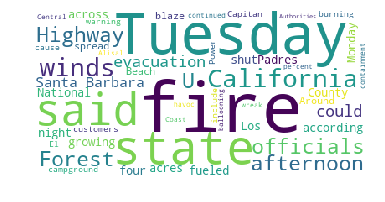

In [19]:
exclude = set(stopwords.words('english'))
wordcloud = WordCloud(background_color = 'white', stopwords = exclude, max_words = 50).generate(text)
plt.imshow(wordcloud)
plt.axis("off")
plt.show();